In [20]:
import pandas as pd
import numpy as np

# import text processs
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
nltk.download('stopwords')

# import models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC

# import model selection
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import cross_val_score
# import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px
import plotly.io as pio

pio.renderers.default = "png"


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/suchattangjarukij/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load the data from files 

In [2]:
# Load the data
x_train = pd.read_csv("./Dataset/x_train.csv",header=None,names=['website','text'])
y_train = pd.read_csv("./Dataset/y_train.csv",header=None,names=['review'])
x_test = pd.read_csv("./Dataset/x_test.csv",header=None,names=['website','text'])
y_test = pd.read_csv("./Dataset/y_test.csv",header=None,names=['review'])
x_train.head()

,website,text
0,amazon,Oh and I forgot to also mention the weird colo...
1,amazon,THAT one didn't work either.
2,amazon,Waste of 13 bucks.
3,amazon,"Product is useless, since it does not have eno..."
4,amazon,None of the three sizes they sent with the hea...


# Preprocessing the data
This code provides a pipeline for text preprocessing and feature extraction using Term Frequency-Inverse Document Frequency (TF-IDF) technique. The pipeline consists of four main functions:

1. **text_preprocessing(text, lemma=True)** function receives a string text as input and preprocesses it using various techniques, including removing non-alphanumeric characters, removing words that contain numbers, converting to lowercase, tokenizing, and removing stop words. Additionally, it can also perform lemmatization or stemming based on the value of the lemma boolean parameter.

2. **TFIDF** class with fit() and transform() methods that performs the feature extraction using the TF-IDF technique. The fit() method receives a pandas Series object containing documents as input and computes various statistics, including the term frequency, inverse document frequency, and document frequency. The transform() method then takes the same pandas Series object as input and applies the computed statistics to generate a sparse matrix of features.

3. **pipe(df : pd.DataFrame,source_col:str = "text" ,target_col:str = "preprocessed_text")** function receives a pandas DataFrame df as input, along with the column names of the source and target columns. It preprocesses the text data in the source column and stores the preprocessed text in the target column. It then creates an instance of the TFIDF class and fits it on the preprocessed text.

4. **extract_features(df : pd.DataFrame,tfidf:TFIDF,source_col:str = "preprocessed_text")** function receives a pandas DataFrame df as input, along with an instance of the TFIDF class and the source column name. It applies the transform() method of the TFIDF class to the preprocessed text in the source column and returns the resulting sparse matrix of features as a pandas DataFrame.

In [3]:
# text preprocessing pipeline
def text_preprocessing(text,lemma=True):
    '''
    text: string
    lemma: boolean, True for lemmatization, False for stemming
    '''
    # remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9]',' ',text)
    # remove words that contain numbers
    text = re.sub(r'\w*\d\w*',' ',text)
    # convert to lower case
    text = text.lower()
    # tokenize
    tokens = word_tokenize(text)
    # remove stop words
    stop_words = stopwords.words('english')
    tokens = [w for w in tokens if w not in stop_words]
    # lemmatize or stem
    if lemma:
        # lemmatize
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(w) for w in tokens]
    else:
        # stem
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(w) for w in tokens]
    # join tokens
    text = ' '.join(tokens)
    return text


#TF-IDF class with fit and transform methods
class TFIDF:
    def __init__(self):
       
        self.tf = None
        self.idf = None
        self.tfidf = None
        self.vocab = None
        self.vocab_size = None
        self.doc_size = None
        self.doc_freq = None
        # tf: term frequency
        # idf: inverse document frequency
        # tfidf: tfidf
        # vocab: vocabulary
        # vocab_size: vocabulary size
        # doc_size: number of documents
        # doc_freq: document frequency
    def fit(self,docs:pd.Series)->object:
        '''
        docs: pd.Series of documents
        '''
        self.doc_size = len(docs) #number of documents
        self.vocab = set() #initialize vocab
        self.doc_freq = {} #initialize doc_freq
        for doc in docs: #for each document in pd.Series
            self.vocab.update(doc.split()) #update vocab
            for word in set(doc.split()): #for each word in the document
                if word in self.doc_freq: #update doc_freq
                    self.doc_freq[word] += 1 
                else:
                    self.doc_freq[word] = 1
        self.vocab_size = len(self.vocab)
        self.vocab = sorted(self.vocab)
        self.idf = {}
        for word in self.vocab:
            self.idf[word] = np.log(self.doc_size/self.doc_freq[word])
        return self

    def transform(self, docs:pd.Series,min_freq=1)->pd.DataFrame:
        '''
        docs: pd.Series of documents
        min_freq: minimum frequency of words to be included in the vocabulary
        '''
        self.tf = {}
        self.tfidf = {}
        #for each document in pd.Series
        for i,doc in docs.iteritems(): 
            self.tf[i] = {}
            self.tfidf[i] = {} #initialize tfidf for each document
            for word in doc.split():
                if word in self.tf[i]:
                    self.tf[i][word] += 1
                else:
                    self.tf[i][word] = 1
            #remove words with frequency less than min_freq
            for i in self.tfidf:
                for word in list(self.tfidf[i]):
                    if self.tf[i][word] < min_freq:
                        del self.tfidf[i][word]
            for word in self.tf[i]: #for each word in the document 
                #if word exists in the self.tfidf[i] dictionary
                # if word in self.tfidf[i]:
                try:
                    self.tfidf[i][word] = self.tf[i][word]*self.idf[word]
                except:
                    pass
                # self.tfidf[i][word] = self.tf[i][word]*self.idf[word]
                    

        
        #create dummy dataframe with the same index as docs and columns as the vocabulary
        ret = pd.DataFrame(index=docs.index,columns=self.vocab)
        #fill the dataframe with tfidf values
        for i in self.tfidf:
            for word in self.tfidf[i]:
                ret.loc[i,word] = self.tfidf[i][word]
        #fill the remaining values with 0
        ret = ret.fillna(0)
        # self.tfidf = pd.DataFrame(self.tfidf).T
        # self.tfidf = self.tfidf.fillna(0).sort_index(axis=1)        
        return ret

def pipe(df : pd.DataFrame,source_col:str = "text" ,target_col:str = "preprocessed_text")->(pd.DataFrame,TFIDF):
    '''
    df: pd.DataFrame
    source_col: column name of the text to be preprocessed
    target_col: column name of the preprocessed text
    '''
    df[target_col] = df[source_col].apply(text_preprocessing)
    tfidf = TFIDF()
    tfidf.fit(df[target_col])
    return df,tfidf

def extract_features(df : pd.DataFrame,tfidf:TFIDF,source_col:str = "preprocessed_text")->pd.DataFrame:
    '''
    df: pd.DataFrame
    tfidf: TFIDF object
    source_col: column name of the preprocessed text
    '''
    features = tfidf.transform(df[source_col])
    return features

def wrapper(df : pd.DataFrame,source_col:str = "text" ,target_col:str = "preprocessed_text")->(pd.DataFrame,TFIDF, pd.DataFrame):
    '''
    df: pd.DataFrame
    source_col: column name of the text to be preprocessed
    target_col: column name of the preprocessed text
    '''
    df,tfidf = pipe(df,source_col,target_col)
    features = extract_features(df,tfidf,target_col)
    return features,tfidf,df

In [4]:
#preprocess text
features,tfidf,x_train = wrapper(x_train)
features.head()

/var/folders/ym/8j6tzspj2sg495vmk_4w19tm0000gn/T/ipykernel_89646/2387001066.py:79: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



,abandoned,abhor,ability,able,abound,abroad,absolute,absolutel,absolutely,absolutley,...,youtube,yucky,yukon,yum,yummy,yun,z,zero,zillion,zombie
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# create baseline model with logistic regression and cv=3
clf = LogisticRegression(
    random_state=0, 
    solver='lbfgs',
    multi_class='multinomial',
    max_iter=1000
    )

scores = cross_val_score(clf, features, y_train["review"], cv=3)
base_accuracy = scores.mean()
print("Accuracy of CV: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Accuracy of CV: 0.71 (+/- 0.02)


# Define test suites
This is a code snippet defining a dictionary of machine learning models and their hyperparameters to be used in a classification task. The goal of the task is to achieve a higher accuracy than a baseline accuracy of 0.71 +/- 0.02. The models included in the dictionary are:

- **Logistic Regression** with the following hyperparameters: random_state=0, solver='lbfgs', multi_class='multinomial', and max_iter=1000.
- **Random Forest** with the following hyperparameters: random_state=0, n_estimators=[10, 50, 100, 200], and max_depth=[3, 5, 10, 15].
- **Naive Bayes** with the following hyperparameters: alpha=[0.1, 0.5, 1.0].
- **Linear SVM classifier** with the following hyperparameters: penalty='l2', random_state=0, and max_iter=10000.
- **SVM classifier** with the following hyperparameters: kernel='linear', random_state=0, max_iter=10000, degree=[2, 3], probability=True, gamma=['scale', 'auto'], and decision_function_shape=['ovo', 'ovr'].

The models and their hyperparameters will be used for hyperparameter tuning and model selection to achieve higher accuracy than the baseline accuracy.

In [6]:
#we need to beat this baseline accuracy of 0.71 +/- 0.02

models = {
    "Logistic Regression": {
        "model": LogisticRegression,
        "params": {
            "random_state": [0],
            "solver": ["lbfgs"],
            "multi_class": ["multinomial"],
            "max_iter": [1000]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier,
        "params": {
            "random_state": [0],
            "n_estimators": [10,50,100, 200],
            "max_depth": [3,5, 10, 15]
        }
    },
    "naive bayes": {
        "model": MultinomialNB,
        "params": {
            "alpha": [0.1, 0.5, 1.0]
        }
    },
    "linear SVM classifier": {
        "model": LinearSVC,
        "params": {
            "penalty": ["l2"],
            "random_state": [0],
            "max_iter": [10000]
        } 
    },
    "svm classifier": {
        "model": SVC,
        "params": {
            "kernel": ["linear"],#must be linear to use ELI5
            "random_state": [0],
            "max_iter": [10000],
            "degree": [2,3],
            "probability": [True],
            "gamma": ["scale", "auto"],
            "decision_function_shape": ["ovo", "ovr"],
        } 
    },
}

# Grid Search
This code block performs a grid search over the hyperparameters of several machine learning models and prints the cross-validation accuracy and standard deviation for each combination of hyperparameters. It then stores the results in a pandas DataFrame called df_models.

The models dictionary contains the names of the models to be tested, along with their respective classes and a dictionary of hyperparameters to test. The ParameterGrid function from the sklearn.model_selection module is used to generate all possible combinations of hyperparameters.

For each combination of hyperparameters, a new instance of the model is created using the hyperparameters, and cross_val_score is used to evaluate the model's accuracy using 3-fold cross-validation. The mean accuracy and standard deviation of the cross-validation scores are then printed for each combination of hyperparameters.

Finally, the results are stored in the df_models DataFrame, which has columns for the model name, hyperparameters, accuracy, and standard deviation. If df_models has not been created yet, it is initialized with the first set of results, and subsequent results are concatenated to the existing DataFrame.

In [7]:
# get cv scores for each model and parameter combination in dataframe
for model_name, mp in models.items():
    for params in ParameterGrid(mp["params"]):
        clf = mp["model"](**params)
        scores = cross_val_score(clf, features, y_train["review"], cv=3, scoring="accuracy", n_jobs=-1)
        print("Accuracy of CV: %0.2f (+/- %0.2f) for %s" % (scores.mean(), scores.std() * 2, model_name))
        df = pd.DataFrame({
            "model": model_name,
            "params": [params],
            "accuracy": scores.mean(),
            "std": scores.std() * 2
        })
        df = df[["model", "params", "accuracy", "std"]]
        if "df_models" not in globals():
            df_models = df
        else:
            df_models = pd.concat([df_models, df])

Accuracy of CV: 0.71 (+/- 0.02) for Logistic Regression
Accuracy of CV: 0.63 (+/- 0.07) for Random Forest
Accuracy of CV: 0.67 (+/- 0.06) for Random Forest
Accuracy of CV: 0.70 (+/- 0.05) for Random Forest
Accuracy of CV: 0.71 (+/- 0.06) for Random Forest
Accuracy of CV: 0.64 (+/- 0.04) for Random Forest
Accuracy of CV: 0.69 (+/- 0.05) for Random Forest
Accuracy of CV: 0.71 (+/- 0.05) for Random Forest
Accuracy of CV: 0.71 (+/- 0.06) for Random Forest
Accuracy of CV: 0.67 (+/- 0.06) for Random Forest
Accuracy of CV: 0.71 (+/- 0.03) for Random Forest
Accuracy of CV: 0.71 (+/- 0.04) for Random Forest
Accuracy of CV: 0.72 (+/- 0.05) for Random Forest
Accuracy of CV: 0.69 (+/- 0.05) for Random Forest
Accuracy of CV: 0.72 (+/- 0.01) for Random Forest
Accuracy of CV: 0.71 (+/- 0.05) for Random Forest
Accuracy of CV: 0.72 (+/- 0.07) for Random Forest
Accuracy of CV: 0.68 (+/- 0.01) for naive bayes
Accuracy of CV: 0.69 (+/- 0.01) for naive bayes
Accuracy of CV: 0.70 (+/- 0.02) for naive bayes


In [8]:
df_models.sort_values(by="accuracy", ascending=False)
best_model = df_models.iloc[df_models["accuracy"].idxmax()]
best_model 

model                                     Logistic Regression
params      {'max_iter': 1000, 'multi_class': 'multinomial...
accuracy                                             0.711667
std                                                  0.018966
Name: 0, dtype: object

In [9]:
#train best model

clf = models[best_model["model"]]["model"](**best_model["params"])
clf.fit(features, y_train["review"])

LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=0)

In [10]:
#evaluate best model with test set
x_test, _  = pipe(x_test,source_col="text",target_col="preprocessed_text")
features = tfidf.transform(x_test["preprocessed_text"])

y_pred = clf.predict(features)
y_predproba = clf.predict_proba(features)
y_true = y_test["review"]
print("Accuracy: %0.2f" % accuracy_score(y_true, y_pred))
print("ROC AUC Score: %0.2f" % roc_auc_score(y_true, y_predproba[:,1]))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("Classification Report:")
print(classification_report(y_true, y_pred))


/var/folders/ym/8j6tzspj2sg495vmk_4w19tm0000gn/T/ipykernel_89646/2387001066.py:79: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



Accuracy: 0.77
ROC AUC Score: 0.82
Confusion Matrix:
[[242  58]
 [ 80 220]]
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.81      0.78       300
           1       0.79      0.73      0.76       300

    accuracy                           0.77       600
   macro avg       0.77      0.77      0.77       600
weighted avg       0.77      0.77      0.77       600



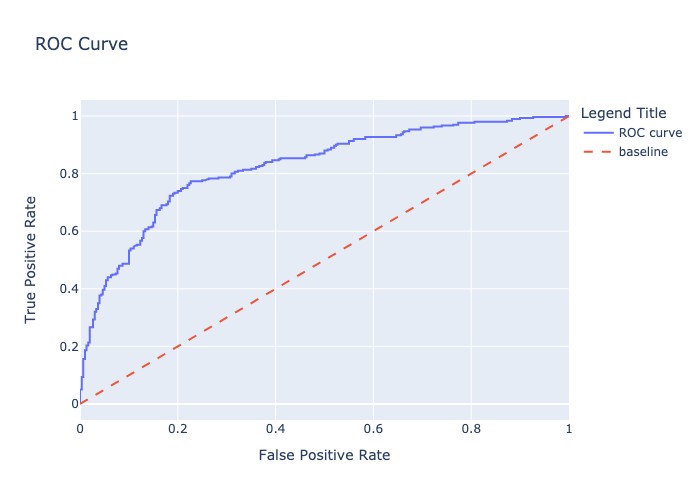

In [22]:
#plot roc curve using plotly
fpr, tpr, thresholds = roc_curve(y_true, y_predproba[:,1])
fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr,
                    mode='lines',
                    name='ROC curve'))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1],
                    mode='lines',
                    name='baseline',
                    line = dict(dash='dash')))
fig.update_layout(
    title="ROC Curve",
    xaxis_title="False Positive Rate",
    yaxis_title="True Positive Rate",
    legend_title="Legend Title",
)
fig.show()




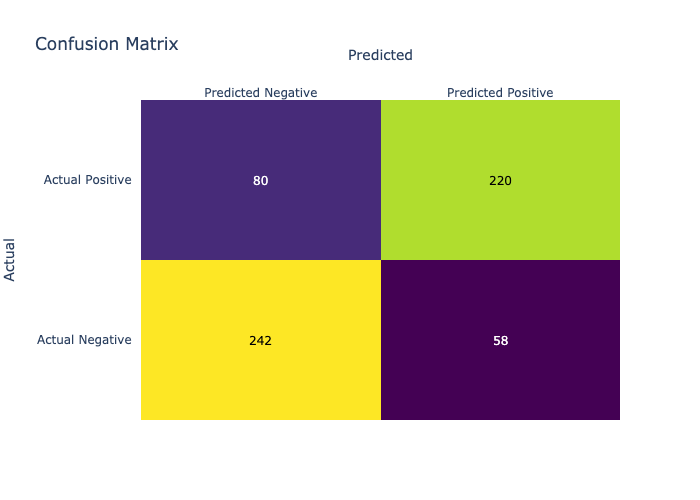

In [21]:
z = confusion_matrix(y_true, y_pred)
x = ["Predicted Negative", "Predicted Positive"]
y = ["Actual Negative", "Actual Positive"]
fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z, colorscale='Viridis')
fig.update_layout(
    title="Confusion Matrix",
    xaxis_title="Predicted",
    yaxis_title="Actual",
    legend_title="Legend Title",
)
fig.show()



In [13]:
# # analyse false positives and false negatives
from copy import deepcopy
foo_df = deepcopy(x_test)
foo_df["review"] = y_test["review"]
foo_df["pred"] = y_pred
foo_df["pred_proba"] = y_predproba[:,1]
foo_df["correct"] = foo_df["review"] == foo_df["pred"]
foo_df["correct"] = foo_df["correct"].apply(lambda x: "correct" if x else "incorrect")
foo_df["pred"] = foo_df["pred"].apply(lambda x: "positive" if x else "negative")
foo_df["review"] = foo_df["review"].apply(lambda x: "positive" if x else "negative")
foo_df.head()


,website,text,preprocessed_text,review,pred,pred_proba,correct
0,amazon,It only recognizes the Phone as its storage de...,recognizes phone storage device,negative,positive,0.965937,incorrect
1,amazon,Disappointing accessory from a good manufacturer.,disappointing accessory good manufacturer,negative,negative,0.104683,correct
2,amazon,The one big drawback of the MP3 player is that...,one big drawback player button phone front cov...,negative,negative,0.000018,correct
3,amazon,This particular model would not work with my M...,particular model would work motorola q smartphone,negative,negative,0.026290,correct
4,amazon,If the two were seperated by a mere 5+ ft I st...,two seperated mere ft started notice excessive...,negative,negative,0.365744,correct


In [14]:
grouped = foo_df.groupby(["review", "pred", "correct"])
grouped.size().unstack(fill_value=0)

correct            correct  incorrect
review   pred                        
negative negative      242          0
         positive        0         58
positive negative        0         80
         positive      220          0

In [15]:
#print top 10 false positives
foo_df[foo_df["review"]=="positive"].sort_values(by="pred_proba", ascending=True)[[
    "text", "preprocessed_text","correct","pred_proba"
]].head(10)

,text,preprocessed_text,correct,pred_proba
526,Today was my first taste of a Buldogis Gourmet...,today first taste buldogis gourmet hot dog tel...,incorrect,2.613781e-07
348,"It has everything you could want... suspense, ...",everything could want suspense drama comedy co...,incorrect,7.674000e-05
377,It handles some tough issues with dignity and ...,handle tough issue dignity grace course shocki...,incorrect,1.667685e-04
398,Director Neil LaBute uses brutal violence to s...,director neil labute us brutal violence sepera...,incorrect,3.379435e-04
307,BLACK WATER is a thriller that manages to comp...,black water thriller manages completely transc...,incorrect,3.459465e-04
120,He was very impressed when going from the orig...,impressed going original battery extended battery,incorrect,6.654952e-04
373,The scenes are often funny and occasionally to...,scene often funny occasionally touching charac...,incorrect,2.915998e-03
136,It plays louder than any other speaker of this...,play louder speaker size price low would think...,incorrect,4.025048e-03
337,It's pretty surprising that this wonderful fil...,pretty surprising wonderful film made hollywoo...,incorrect,4.047444e-03
391,My 8/10 score is mostly for the plot.,score mostly plot,incorrect,4.450242e-03


In [16]:
#print top 10 false negative
foo_df[foo_df["review"]=="negative"].sort_values(by="pred_proba", ascending=False)[[
    "text", "preprocessed_text","correct","pred_proba"
]].head(10)

,text,preprocessed_text,correct,pred_proba
232,The only consistent thread holding the series ...,consistent thread holding series together amaz...,incorrect,0.999979
79,Items stated as included from the description ...,item stated included description included,incorrect,0.999687
39,none of the new ones have ever quite worked pr...,none new one ever quite worked properly,incorrect,0.999262
67,Not a good bargain.,good bargain,incorrect,0.997993
92,"however, my girl was complain that some time t...",however girl complain time phone wake like nor...,incorrect,0.997494
272,This film has no redeeming features.,film redeeming feature,incorrect,0.997061
449,"The whole experience was underwhelming, and I ...",whole experience underwhelming think go ninja ...,incorrect,0.995753
244,The directing and the cinematography aren't qu...,directing cinematography quite good,incorrect,0.995247
491,"After 20 minutes wait, I got a table.",minute wait got table,incorrect,0.992750
475,The feel of the dining room was more college c...,feel dining room college cooking course high c...,incorrect,0.988789
